In [1]:
#import libraries

import tensorflow as tf
import numpy as np
from keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
import math as mt
from tensorflow import keras
from keras import layers
import os
import keras.backend as k
import logomaker as lm
import seaborn as sns
from keras import backend

model_pred='new_cut_2001_KC_G'
predictorKC = load_model('/home/florian/projet/models/'+ model_pred +'/'+ model_pred+ '.h5', compile=False)
pred_name='new_cut_2001_T1'
predictorT1 = load_model('/home/florian/projet/models/'+ pred_name +'/'+ pred_name+ '.h5', compile=False)

with np.load('/home/florian/projet/r6.16/seq.npz') as f:
    X_2L = f['2L']
    X_3R = f['3R']

2023-06-23 16:55:51.982700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 16:55:52.042646: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-23 16:55:52.353733: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dell3/anaconda3/envs/workenv/lib/
2023-06-23 16:55:52.353777: W tensorflow/compiler/xla/str

In [2]:
def undifined_rate(seq):
    c=0
    for i in seq:
        if 0.2<max(i)<0.3:
            c+=1
    return(c/len(seq))   

def sequence_entropy(seq):
    return(sum(np.sum(-seq*np.log(seq+k.epsilon()), axis=1)))
    
def GC_content(seq):
    c=0
    for i in seq:
        if i == "G":
            c+=1
        elif i == "C":
            c+1
    return (round(c/len(seq)*100,2))

def force_ohe(seq):
    max=0
    seq2=np.copy(seq)
    for i in range(len(seq2)):
        new=[0,0,0,0]
        max=np.max(seq2[i])
        if max==0.25:
            new[np.random.randint(0,3)]=1
        else:
            new=np.where(seq2[i]==np.max(seq2[i]),1,0)
        seq2[i]=new
    return (seq2)

def random_ohe_sequence(length):
    return(np.eye(4)[np.random.randint(0,3,length)])

def fast_pred(input,model):
    return model(tf.cast(input,tf.float32))

def fast_pred_seq(input,window_start,model,size=2001):
    X=[]
    for i in range(window_start,window_start+size):
        X.append(np.array(fast_pred(input[:,i-(size//2):i+(size//2)+1],model))[0])
    return(X)

def fast_pred_whole_seq(input,model,size=2001):
    X=[]
    length=len(np.array(input[0]))
    for i in range(size//2,length-(size//2),10):
        X.append(np.array(fast_pred(input[:,i-(size//2):i+(size//2)+1],model))[0])
    return([0 for i in range(0,size//2,10)] + X +[0 for i in range(0,size//2,10)])

def ohd(seq):
    seq2=list()
    mapping = {"[1 0 0 0]":"A", "[0 1 0 0]":"C", "[0 0 1 0]":"G", "[0 0 0 1]":"T"}
    for i in seq:
        seq2.append(mapping[str(i)] if str(i) in mapping.keys() else "x")
    return ''.join(seq2)

from numpy.lib.stride_tricks import as_strided
def sliding_window_view(x, window_shape, axis = None, *,
                        
                        subok=False, writeable=False):

    window_shape = (tuple(window_shape)
                    if np.iterable(window_shape)
                    else (window_shape,))
    # first convert input to array, possibly keeping subclass
    x = np.array(x, copy=False, subok=subok)

    window_shape_array = np.array(window_shape)
    if np.any(window_shape_array < 0):
        raise ValueError('`window_shape` cannot contain negative values')

    if axis is None:
        axis = tuple(range(x.ndim))
        if len(window_shape) != len(axis):
            raise ValueError(f'Since axis is `None`, must provide '
                             f'window_shape for all dimensions of `x`; '
                             f'got {len(window_shape)} window_shape elements '
                             f'and `x.ndim` is {x.ndim}.')
    else:
        axis = normalize_axis_tuple(axis, x.ndim, allow_duplicate=True)
        if len(window_shape) != len(axis):
            raise ValueError(f'Must provide matching length window_shape and '
                             f'axis; got {len(window_shape)} window_shape '
                             f'elements and {len(axis)} axes elements.')

    out_strides = x.strides + tuple(x.strides[ax] for ax in axis)

    # note: same axis can be windowed repeatedly
    x_shape_trimmed = list(x.shape)
    for ax, dim in zip(axis, window_shape):
        if x_shape_trimmed[ax] < dim:
            raise ValueError(
                'window shape cannot be larger than input array shape')
        x_shape_trimmed[ax] -= dim - 1
    out_shape = tuple(x_shape_trimmed) + window_shape
    return as_strided(x, strides=out_strides, shape=out_shape,
                      subok=subok, writeable=writeable)

def seq_similarity(seq1, seq2):
    if len(seq1) != len(seq2):
        raise ValueError("Les séquences doivent avoir la même longueur.")
    
    hamming_distance = sum(a != b for a, b in zip(seq1, seq2))
    similarity = 1 - (hamming_distance / len(seq1))
    
    return similarity

In [3]:
def kmer_counts(one_hots, k, order='ACGT', includeN=True, as_pandas=True):
    """Compute kmer occurences in one-hot encoded sequence."""
    # Convert input into list-like of one_hot 2D-arrays
    # If 3D-array optionnally use faster implementation
    fast = False
    if isinstance(one_hots, dict):
        one_hots = list(one_hots.values())
    elif isinstance(one_hots, np.ndarray):
        if one_hots.ndim == 2:
            # single array turned into list of one array
            one_hots = [one_hots]
        elif one_hots.ndim == 3:
            # Check that last dimension is 4
            assert one_hots.shape[2] == 4
            fast = True
    if fast:  # Faster on 3D array
        # Initialise kD array
        all_counts = np.zeros(tuple(5 for i in range(k)), dtype=int)
        if k == 1:
            # Count each base
            all_counts[:4] = one_hots.sum(axis=(0, 1))
            # Count leftover as Ns
            all_counts[4] = (len(one_hots) * one_hots.shape[1]
                             - all_counts[:4].sum())
        else:
            # Convert one_hot to integer tokens
            tokens = (np.argmax(one_hots, axis=-1)
                      + 4 * (np.sum(one_hots, axis=-1) != 1))
            # Get kmers with sliding_window_view
            kmers = sliding_window_view(tokens, (1, k)).reshape(-1, k)
            # Count kmers in the kD array
            np.add.at(all_counts, tuple(kmers[:, i] for i in range(k)), 1)
    else:  # Iterate over one-hot encoded arrays
        # Initialise kD array
        all_counts = np.zeros(tuple(5 for i in range(k)), dtype=int)
        for oh in one_hots:
            # Check that arrays are 2D with a shape of 4 in the 2nd dimension
            assert oh.ndim == 2
            assert oh.shape[1] == 4
            if k == 1:
                # Count each base
                all_counts[:4] += oh.sum(axis=0)
                # Count leftover as Ns
                all_counts[4] += len(oh) - oh.sum()
            else:
                # Convert one_hot to integer tokens
                tokens = np.argmax(oh, axis=-1) + 4*(np.sum(oh, axis=-1) != 1)
                # Get kmers with sliding_window_view
                kmers = sliding_window_view(tokens, k)
                # Count kmers in the kD array
                np.add.at(all_counts, tuple(kmers[:, i] for i in range(k)), 1)
    # Format output
    if includeN:
        order += 'N'
    else:
        all_counts = all_counts[tuple(slice(0, -1) for i in range(k))]
    if as_pandas:
        ser = pd.Series(
            all_counts.ravel(),
            index=pd.MultiIndex.from_product([list(order)]*k))
        return ser.sort_index()
    else:
        return all_counts

In [60]:
with np.load('/home/florian/projet/cell_types/scATACseq_KC_G.dedup.no_blacklist.RPGCnormalized.bw.npz') as f:
    Y_2L=f['2L'][0]
cut=50
Y_2L[Y_2L >= cut] = cut
Y_2L=Y_2L/cut

In [109]:
realseq=np.copy(X_2L[248450:250450])

In [111]:
fakeseq=np.copy(seq_generated[0][2000:4000].astype("int"))

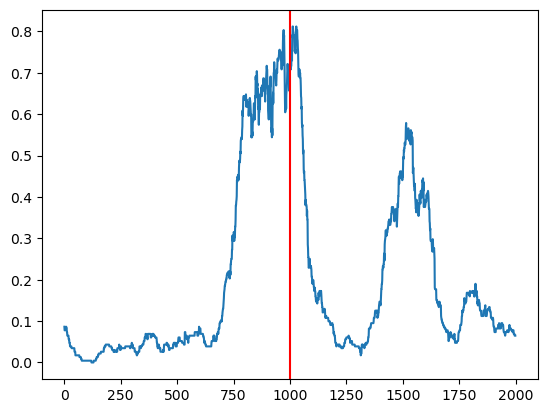

In [85]:
plt.plot(Y_2L[248450:250450])
plt.axvline(x=1000, color='red')

(200.0, 400.0)

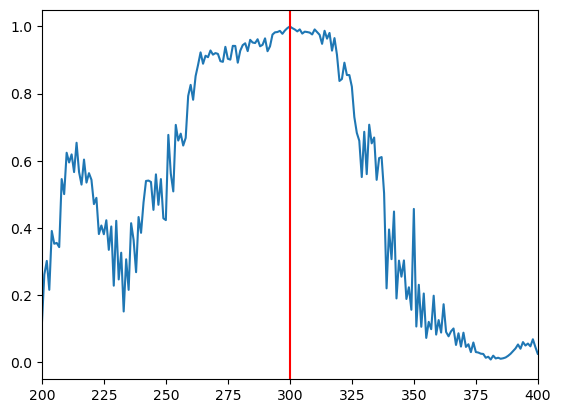

: 

In [121]:
plt.plot(LKC,label='KC')
plt.axvline(x=300, color='red')
plt.xlim(200,400)

In [115]:
seq_similarity(ohd(fakeseq[950:1050]),ohd(realseq[950:1050]))

0.28

In [3]:
# Générer une séquence d'ADN à partir du modèle
modelgen = load_model('/home/florian/projet/generators/generatorRL.h5', compile=False)
seq_generated = modelgen.predict(tf.random.normal((1, 1)))
model_name='new_cut_2001_KC_G'
modelpredict = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
seq_predicted = modelpredict.predict(seq_generated)
del modelgen, modelpredict

1/1 [==============================] - 0s 399ms/step


2023-06-02 11:08:55.448608: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-02 11:08:55.854518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


1/1 [==============================] - 1s 752ms/step


2023-06-02 11:08:56.227232: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [6]:
seq_generated,seq_predicted

(array([[[0.24988578, 0.24988578, 0.24988578, 0.25034267],
         [0.25146943, 0.24893247, 0.25066563, 0.24893247],
         [0.25      , 0.25      , 0.25      , 0.25      ],
         ...,
         [0.25025204, 0.2505054 , 0.2496213 , 0.2496213 ],
         [0.24972644, 0.24972644, 0.24972644, 0.2508207 ],
         [0.25180018, 0.24935949, 0.24948084, 0.24935949]]], dtype=float32),
 array([[2.843621e-07]], dtype=float32))

In [8]:

generator= tf.keras.models.Sequential([
        keras.Input(shape=(1)),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense((40000), activation="relu"),
        tf.keras.layers.Reshape((10000,4)),
        tf.keras.layers.Lambda(lambda x: tf.nn.softmax(x, axis=2))
        ])

class RL(keras.Model):
    def __init__(self, predictor, generator,requested_peak_height,requested_peak_loc):
        super(RL, self).__init__()
        self.predictor = predictor
        self.generator = generator
        self.requested_peak_height=requested_peak_height
        self.requested_peak_loc=requested_peak_loc

    def compile(self, g_optimizer, loss_fn):
        super(RL, self).compile()
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    # @tf.function
    # def maybe_changeLR(self, g_loss):
    #     a=self.g_optimizer.lr.read_value()
    #     print(a)
    #     if g_loss >= self.requested_peak_height/2:
    #         self.g_optimizer.lr.assign(1)
    #     else:
    #         self.g_optimizer.lr.assign(a*tf.math.exp(-0.1))

    #     print(a)

    def train_step(self,_):

        with tf.GradientTape() as tape:
            seq=self.generator(tf.random.normal((1, 1)))[:,self.requested_peak_loc-1000:self.requested_peak_loc+1001]
            predictions = self.predictor(seq)
            g_loss = self.loss_fn(self.requested_peak_height, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        # self.maybe_changeLR(g_loss)
 
        return {"g_loss": g_loss}

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,patience=5, min_lr=0.001)

In [9]:
model_name='new_cut_2001_KC_G'
predictor = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)

rl = RL(predictor=predictor, generator=generator,requested_peak_height=0.8,requested_peak_loc=5000)

rl.compile(g_optimizer=keras.optimizers.Adam(learning_rate=1),
         loss_fn=keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM))

history=rl.fit(tf.random.normal((1, 1)), epochs=50)#, callbacks=[reduce_lr])

Epoch 1/50


2023-05-05 15:48:12.756659: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3f32ba2490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-05 15:48:12.756674: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-05 15:48:12.765091: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-05 15:48:12.867569: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-05 15:48:12.892000: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 1s 733ms/step - g_loss: 0.8000
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - g_loss: 0.8000
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 4/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 6/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - g_loss: 0.8000
Epoch 10/50
1/1 [==============================] - 0s 3ms/step - g_loss: 0.8000
Epoch 11/50
1/1 [==============================] - 0s 4ms/step - g_loss: 0.8000
Epoch 12/50
1/1 [==============================] - 0s 5ms/step - g_loss: 0.8000
Epoch 13/50
1/1 [==============================] - 0s 3ms/

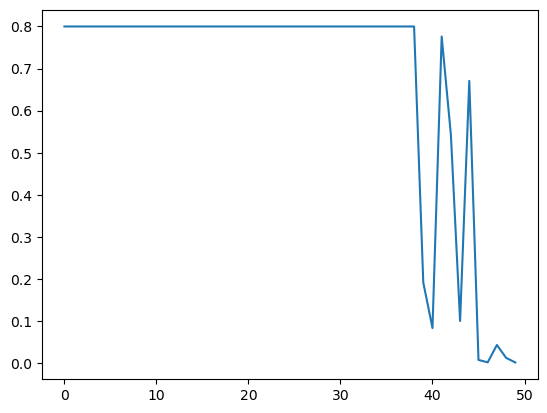

In [10]:
hist_df = pd.DataFrame(history.history) 
plt.plot(hist_df,label='loss')

In [49]:
seq1=rl.generator(tf.constant([0.1]))
seq2=rl.generator(tf.constant([0.9]))

In [17]:
L=fast_pred_seq(seq,window_start=4000,model=predictor,size=2001)

In [360]:
Lfull=fast_pred_whole_seq(seq,model=predictor)

In [19]:
Lfull1=fast_pred_whole_seq(seq1,model=predictor)
Lfull2=fast_pred_whole_seq(seq2,model=predictor)

/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


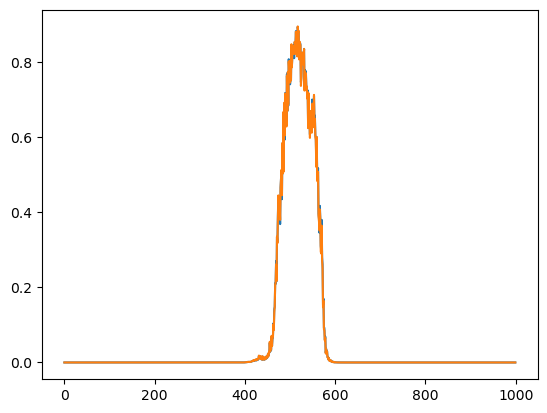

In [20]:
plt.plot(Lfull1)
plt.plot(Lfull2)

In [61]:
seq1,seq2

(<tf.Tensor: shape=(1, 10000, 4), dtype=float32, numpy=
 array([[[0.29096353, 0.23528711, 0.23528711, 0.23846225],
         [0.2284247 , 0.2465257 , 0.23974851, 0.2853011 ],
         [0.24886386, 0.24886386, 0.24886386, 0.25340843],
         ...,
         [0.24158771, 0.2538151 , 0.24158771, 0.2630095 ],
         [0.24486396, 0.27335063, 0.23215218, 0.24963328],
         [0.25757158, 0.26343003, 0.22679976, 0.25219864]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 10000, 4), dtype=float32, numpy=
 array([[[0.29070714, 0.23643096, 0.23643096, 0.23643096],
         [0.23545791, 0.2535034 , 0.23562671, 0.27541193],
         [0.24857995, 0.24857995, 0.24857995, 0.2542601 ],
         ...,
         [0.24369319, 0.25565547, 0.24369319, 0.25695813],
         [0.24278596, 0.26873428, 0.23461801, 0.25386176],
         [0.2606971 , 0.26555744, 0.23001789, 0.24372756]]], dtype=float32)>)

In [9]:
start = 5000
stop = start + 50

In [64]:
# seq=np.array(seq)
# seq=seq.reshape(10000,4)
logo1=pd.DataFrame(np.array(seq1).reshape(10_000,4)[start:stop], columns=["A", "C", "G", "T"])
logo2=pd.DataFrame(np.array(seq2).reshape(10_000,4)[start:stop], columns=["A", "C", "G", "T"])

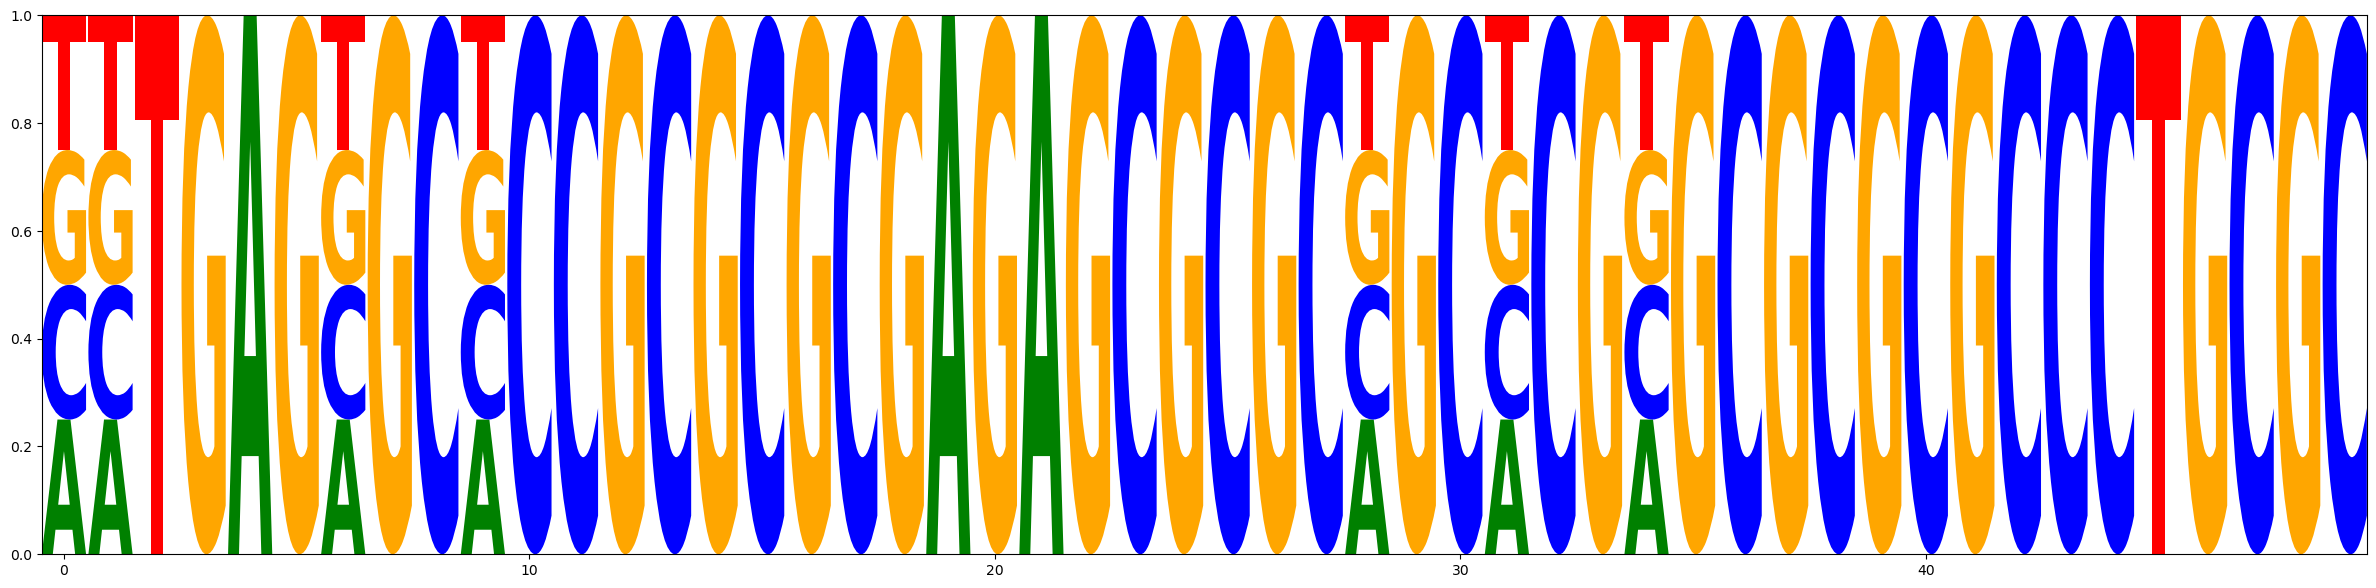

In [65]:
lm.Logo(logo1, figsize=(30, 7))

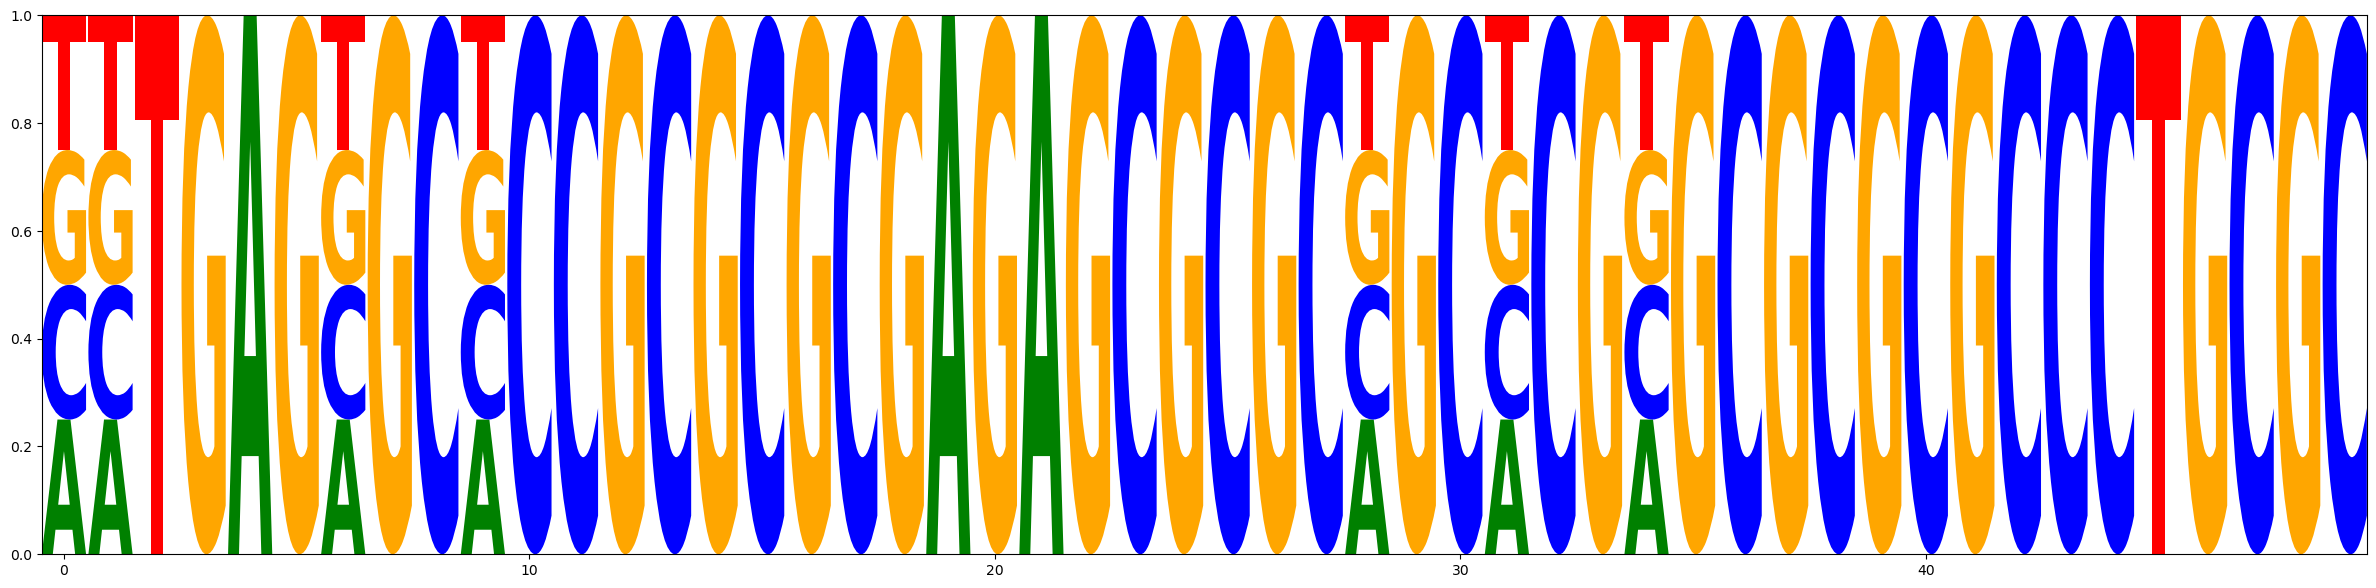

In [66]:
lm.Logo(logo2, figsize=(30, 7))

In [20]:
model_name='GAN_mitigated_halfpeak_correct'

In [3]:
model_name='GAN_KConly'

In [21]:
model_name='GAN_differential_peaks'

In [4]:
model_name='GAN_differential_peaks2'

In [4]:
model_name='GAN_differential_peaks_mitigated'

In [4]:
model_name='GAN_differential_peaks_fixed'

In [4]:
model_name='GAN_differential_peaks_fixed_KCvsALL'

In [5]:
model_name='GAN_differential_peaks_KCvsALL'

In [4]:
model_name='GAN_differential_peaks_50k'

In [4]:
model_name='GAN_50k'

In [5]:
modelgen = load_model('/home/florian/projet/generators/'+model_name+'_G.h5', compile=False)
modeldis = load_model('/home/florian/projet/generators/'+model_name+'_D.h5', compile=False)

In [6]:
L1=[]
L2=[]
L3=[]
for i in range (100):
    a=modelgen.predict(tf.random.normal((1, 10)))
    b=modeldis.predict(a)
    L1.append(undifined_rate(a[0]))
    L2.append(b[0][0])
    # L3.append(GC_content(ohd(force_ohe(a[0]))))
mean_score=sum(L2)/len(L2)
mean_undifined_rate=sum(L1)/len(L1)
# mean_GC_content=sum(L3)/len(L3)

L2L=[]
L3R=[]
for i in [i for i in range(0,len(X_2L),len(X_2L)//100-10000)]:
    L2L.append(modeldis.predict(sliding_window_view(X_2L, (50000, 4))[i])[0][0])
mean_score2L=sum(L2L)/len(L2L)

for i in [i for i in range(0,len(X_3R),len(X_3R)//100-10000)]:
    L3R.append(modeldis.predict(sliding_window_view(X_3R, (50000, 4))[i])[0][0])
mean_score3R=sum(L3R)/len(L3R)

LRD=[]
for i in range(100):
    LRD.append(modeldis.predict(random_ohe_sequence(50_000).reshape(1,50000,4))[0][0])
mean_scoreRD=sum(LRD)/len(LRD)

seq_generated1 = modelgen.predict(tf.random.normal((1, 10)))
seq_generated2 = modelgen.predict(tf.random.normal((1, 10)))
seq_generated3 = modelgen.predict(tf.random.normal((1, 10)))
seq_generated4 = modelgen.predict(tf.random.normal((1, 10)))

df = pd.read_csv ('/home/florian/projet/generators/'+model_name+'history.csv')

2023-06-23 16:56:23.472899: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-23 16:56:23.757693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


1/1 [==============================] - 0s 10ms/step


2023-06-23 16:56:24.137074: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 10ms/step


/tmp/ipykernel_3541497/2925914968.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,1)


(0.0, 10.0, 0.0, 10.0)

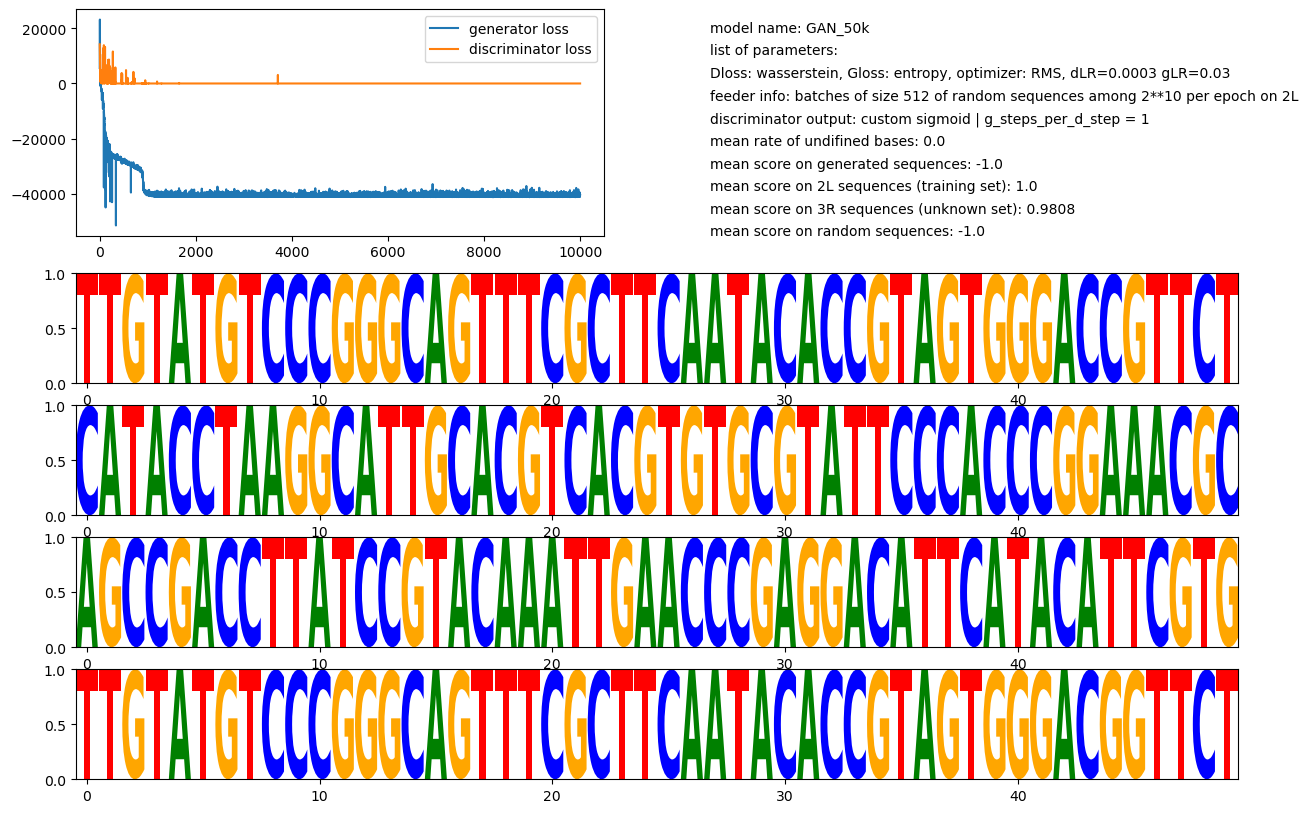

In [7]:
#global plot:
start = 4975
stop= start+50

figs,axes = plt.subplots(6,1,figsize=(15,10))
lm.Logo(pd.DataFrame(np.array(seq_generated1).reshape(50_000,4)[start:stop], columns=["A", "C", "G", "T"]),ax=axes[2])
lm.Logo(pd.DataFrame(np.array(seq_generated2).reshape(50_000,4)[start:stop], columns=["A", "C", "G", "T"]),ax=axes[3])
lm.Logo(pd.DataFrame(np.array(seq_generated3).reshape(50_000,4)[start:stop], columns=["A", "C", "G", "T"]),ax=axes[4])
lm.Logo(pd.DataFrame(np.array(seq_generated4).reshape(50_000,4)[start:stop], columns=["A", "C", "G", "T"]),ax=axes[5])

# plt.subplot(3,4,1)
# plt.plot(df['g_loss'])
# plt.title("generator loss")
# plt.subplot(3,4,2)
# plt.plot(df['d_loss'],color='darkorange')
# plt.title("discriminator loss")
plt.subplot(3,2,1)
plt.plot(df['g_loss'],label="generator loss")
plt.plot(df['d_loss'],label='discriminator loss')
plt.legend()


plt.subplot(3,2,2)
plt.axis([0, 10, 0, 10])
plt.text(0,9,"model name: " + model_name)
plt.text(0,8,"list of parameters:")
plt.text(0,7,"Dloss: wasserstein, Gloss: entropy, optimizer: RMS, dLR=0.0003 gLR=0.03 ")
plt.text(0,6,"feeder info: batches of size 512 of random sequences among 2**10 per epoch on 2L")
plt.text(0,5,"discriminator output: custom sigmoid | g_steps_per_d_step = 1")
plt.text(0,4,"mean rate of undifined bases: "+ str(round(mean_undifined_rate,4)))# + "mean GC content: " + str(round(mean_GC_content,1))+" %")
plt.text(0,3,"mean score on generated sequences: " + str(round(mean_score,4)))
plt.text(0,2,"mean score on 2L sequences (training set): " + str(round(mean_score2L,4)))
plt.text(0,1,"mean score on 3R sequences (unknown set): " + str(round(mean_score3R,4)))
plt.text(0,0,"mean score on random sequences: " + str(round(mean_scoreRD,4)))
plt.axis("off")

1/1 [==============================] - 0s 13ms/step


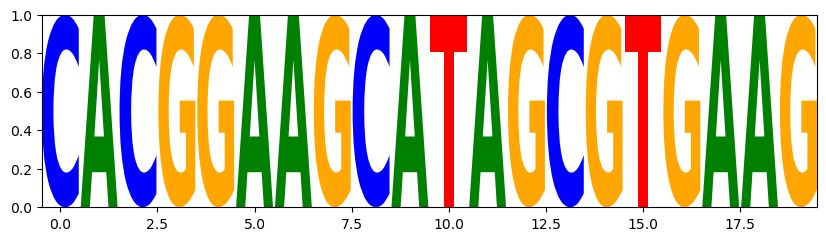

In [8]:
seq_generated = modelgen.predict(tf.random.normal((1, 10)))
lm.Logo(pd.DataFrame(np.array(seq_generated).reshape(50_000,4)[0:20], columns=["A", "C", "G", "T"]))

In [9]:
LKC=fast_pred_whole_seq(seq_generated,model=predictorKC)
LT1=fast_pred_whole_seq(seq_generated,model=predictorT1)

/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


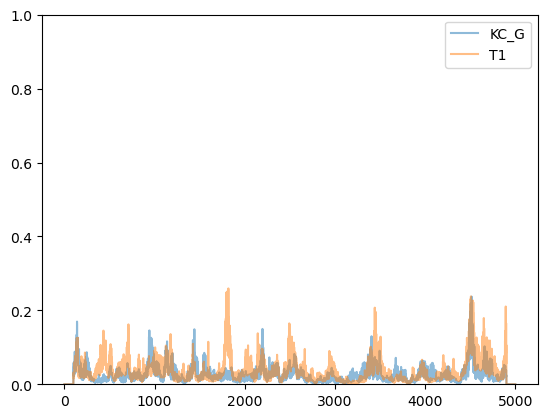

In [10]:
plt.plot(LKC,label='KC_G',alpha=0.5)
plt.plot(LT1,label='T1',alpha=0.5)
plt.ylim(0,1)
# plt.xlim(200,400)
plt.legend()

In [11]:
model_name='new_cut_2001_KC_G'
modelKC_G = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_KC_AB'
modelKC_AB = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_KC_ABp'
modelKC_ABp = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)

model_name='new_cut_2001_T1'
modelT1 = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_T2'
modelT2 = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_T2a'
modelT2a = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_T3'
modelT3 = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_T4'
modelT4 = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_T5'
modelT5 = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)

model_name='new_cut_2001_Subperineurialglia'
modelPerineurialglia = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
model_name='new_cut_2001_Perineurialglia'
modelSubperineurialglia = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)

In [12]:
fast_mod1_T1=fast_pred_whole_seq(seq_generated,modelT1)
fast_mod1_T2=fast_pred_whole_seq(seq_generated,modelT2)
fast_mod1_T2a=fast_pred_whole_seq(seq_generated,modelT2a)
fast_mod1_T3=fast_pred_whole_seq(seq_generated,modelT3)
fast_mod1_T4=fast_pred_whole_seq(seq_generated,modelT4)
fast_mod1_T5=fast_pred_whole_seq(seq_generated,modelT5)
fast_mod1_KC_G=fast_pred_whole_seq(seq_generated,modelKC_G)
fast_mod1_KC_AB=fast_pred_whole_seq(seq_generated,modelKC_AB)
fast_mod1_KC_ABp=fast_pred_whole_seq(seq_generated,modelKC_ABp)
fast_mod1_Perineurialglia=fast_pred_whole_seq(seq_generated,modelPerineurialglia)
fast_mod1_Subperineurialglia=fast_pred_whole_seq(seq_generated,modelSubperineurialglia)

(0.0, 1.0)

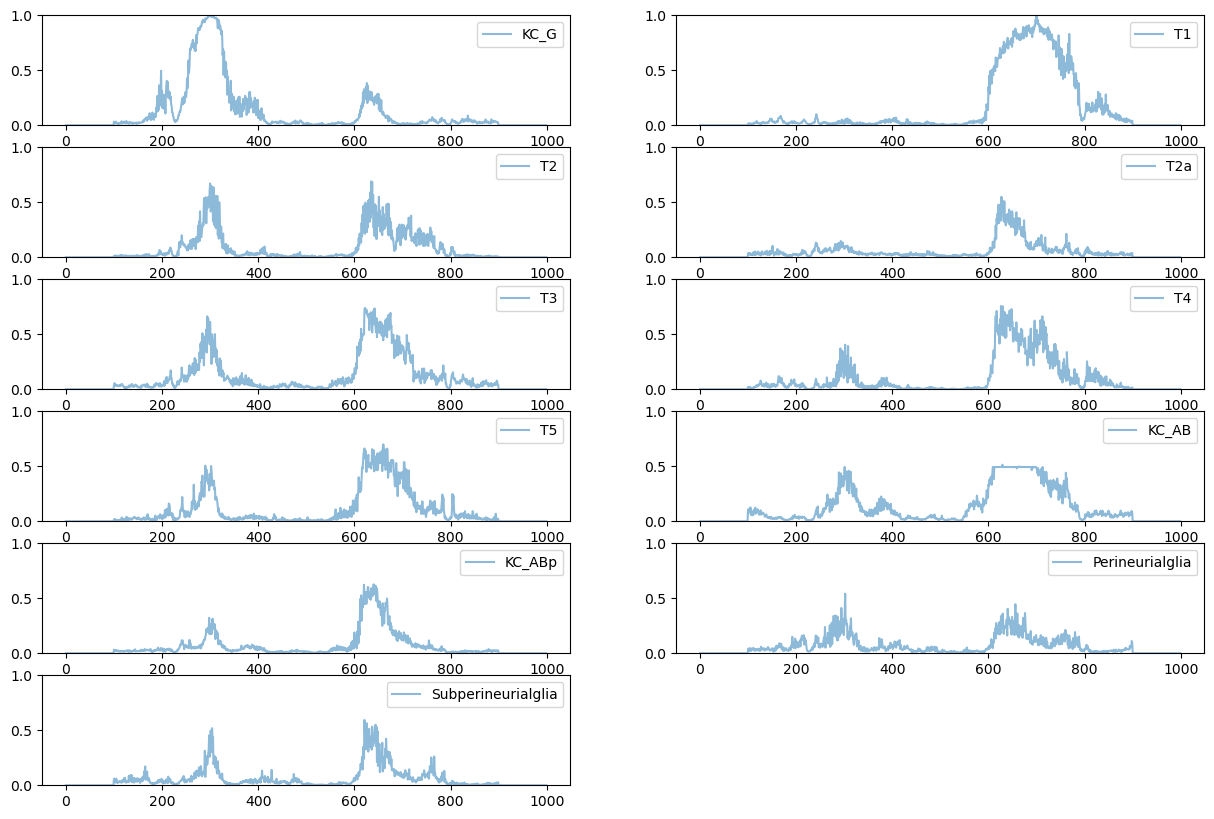

In [13]:
plt.figure(figsize=(15,10))

plt.subplot(6,2,1)
plt.plot(fast_mod1_KC_G,label='KC_G',alpha=0.5)
plt.legend()
plt.ylim(0,1)

plt.subplot(6,2,2)
plt.plot(fast_mod1_T1,label='T1',alpha=0.5)
plt.legend()
plt.ylim(0,1)

plt.subplot(6,2,3)
plt.plot(fast_mod1_T2,label='T2',alpha=0.5)
plt.legend()
plt.ylim(0,1)

plt.subplot(6,2,4)
plt.plot(fast_mod1_T2a,label='T2a',alpha=0.5)
plt.legend()
plt.ylim(0,1)

plt.subplot(6,2,5)
plt.plot(fast_mod1_T3,label='T3',alpha=0.5)
plt.legend()
plt.ylim(0,1)

plt.subplot(6,2,6)
plt.plot(fast_mod1_T4,label='T4',alpha=0.5)
plt.legend()
plt.ylim(0,1)

plt.subplot(6,2,7)
plt.plot(fast_mod1_T5,label='T5',alpha=0.5)
plt.legend()
plt.ylim(0,1)

plt.subplot(6,2,8)
plt.plot(fast_mod1_KC_AB,label='KC_AB',alpha=0.5)
plt.legend()
plt.ylim(0,1)

plt.subplot(6,2,9)
plt.plot(fast_mod1_KC_ABp,label='KC_ABp',alpha=0.5)
plt.legend()
plt.ylim(0,1)

plt.subplot(6,2,10)
plt.plot(fast_mod1_Perineurialglia,label='Perineurialglia',alpha=0.5)
plt.legend()
plt.ylim(0,1)

plt.subplot(6,2,11)
plt.plot(fast_mod1_Subperineurialglia,label='Subperineurialglia',alpha=0.5)
plt.legend()
plt.ylim(0,1)

In [14]:
data1=pd.DataFrame((fast_mod1_KC_G,
                fast_mod1_KC_AB,
              fast_mod1_KC_ABp,
              fast_mod1_T1,
              fast_mod1_T2,
              fast_mod1_T2a,
              fast_mod1_T3,
              fast_mod1_T4,
              fast_mod1_T5,
              fast_mod1_Perineurialglia,
              fast_mod1_Subperineurialglia))

/tmp/ipykernel_2960936/1823040456.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


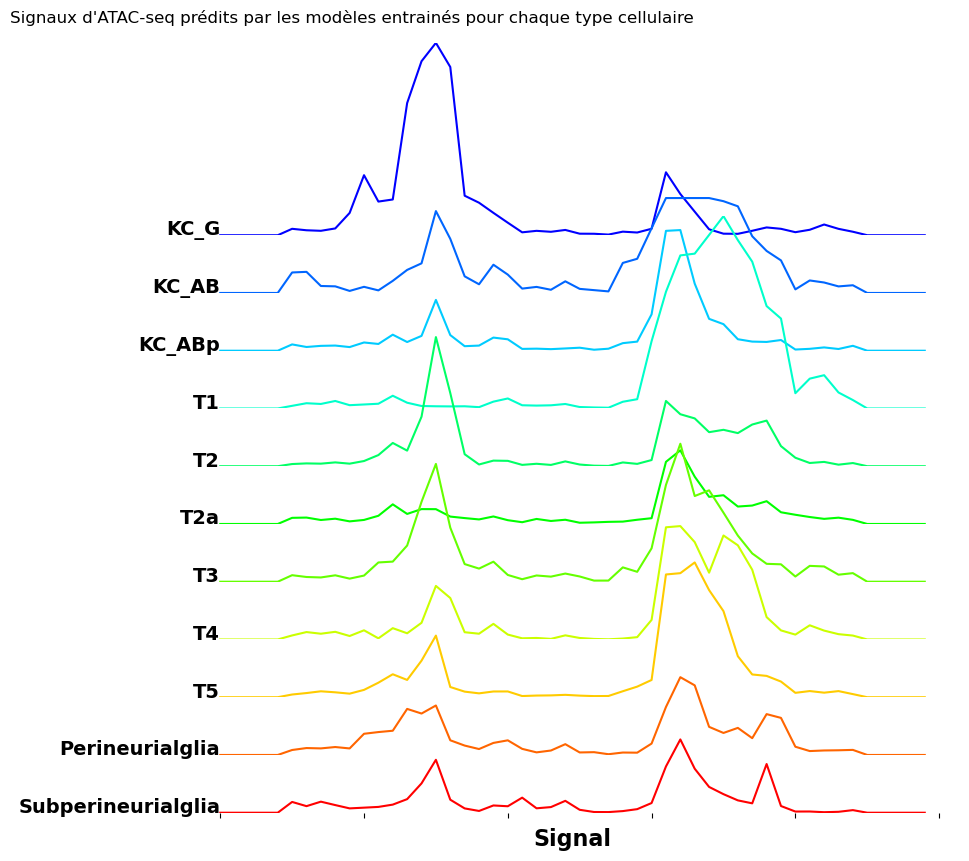

: 

In [16]:
import matplotlib.gridspec as grid_spec
cell_types=['KC_G','KC_AB','KC_ABp','T1','T2','T2a','T3','T4','T5','Perineurialglia','Subperineurialglia']
colors=['#0000ff', '#0066ff', '#00cbff', '#00ffcb', '#00ff65', '#00ff00', '#65ff00', '#cbff00', '#ffcb00', '#ff6500', '#ff0000']

gs = (grid_spec.GridSpec(len(cell_types),1))

fig = plt.figure(figsize=(10,10))

i = 0

#creating empty list
ax_objs = []

for j in range(len(cell_types)):
    # creating new axes object and appending to ax_objs
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    plot = (data1.iloc()[j][::20])

    # filling the space beneath the distribution
    ax_objs[-1].plot(plot,color=colors[i])
    # ax_objs[-1].fill_between(np.arange(len(plot)),plot,color=colors[i])
    # ax_objs[-1].plot(np.arange(0,len(plot))+0.15,plot,color="#f0f0f0",lw=1)

    # setting uniform x and y lims
    ax_objs[-1].set_ylim(0,1)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])
    ax_objs[-1].set_yticks([])

    if i == len(cell_types)-1:
        ax_objs[-1].set_xlabel("Signal", fontsize=16,fontweight="bold")
        ax_objs[-1].set_xticklabels([])
    else:
        ax_objs[-1].set_xticklabels([])
        ax_objs[-1].set_xticks([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.02,0,cell_types[j],fontweight="bold",fontsize=14,ha="right")

    i += 1

gs.update(hspace= -0.7)
fig.text(-0.05,0.9,"Signaux d'ATAC-seq prédits par les modèles entrainés pour chaque type cellulaire",fontsize=12)
plt.tight_layout()
plt.show()

In [14]:
b=kmer_counts(one_hots=seq_generated[0].astype('int'),k=2,includeN=False,as_pandas=False)
b=b/np.sum(b)
a=kmer_counts(one_hots=X_2L[248450-4000:250450+4000],k=2,includeN=False,as_pandas=False)
a=a/np.sum(a)


Text(0.5, 1.0, 'GAN sequence')

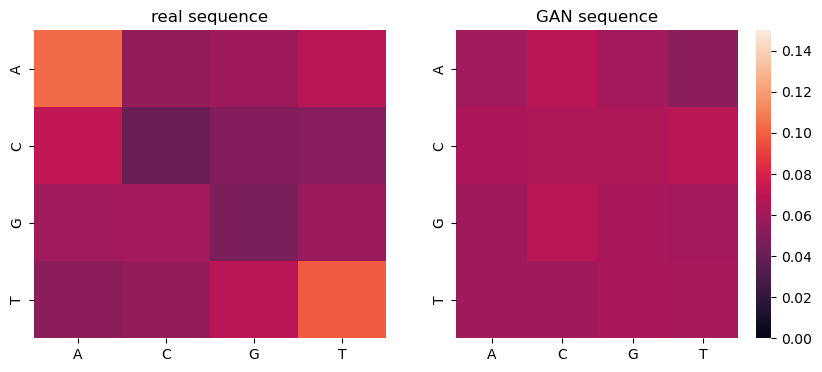

In [17]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.heatmap((a), vmin=0, vmax=0.15,xticklabels=["A","C","G","T"],yticklabels=["A","C","G","T"],cbar=False)#,center=0)
plt.title('real sequence')

plt.subplot(1,2,2)
sns.heatmap((b), vmin=0, vmax=0.15,xticklabels=["A","C","G","T"],yticklabels=["A","C","G","T"])#,center=0)
plt.title('GAN sequence')

In [25]:
gen_loss = pd.read_csv ('/home/florian/projet/generators/'+model_name+'gen_loss_history.csv')

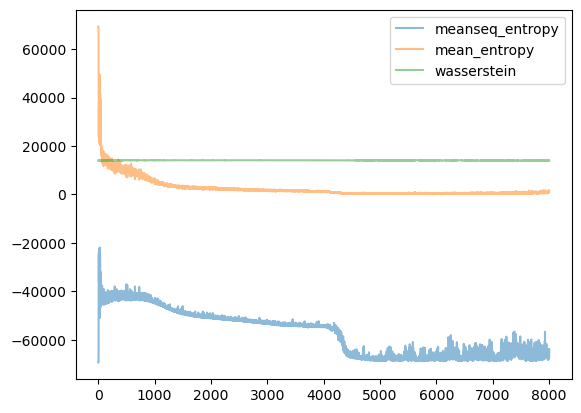

In [29]:
plt.plot(-gen_loss['meanseq_entropy'],label='meanseq_entropy',alpha=0.5)
plt.plot(gen_loss['mean_entropy'],label='mean_entropy',alpha=0.5)
plt.plot(gen_loss['wasserstein'],label='wasserstein',alpha=0.5)
plt.legend()

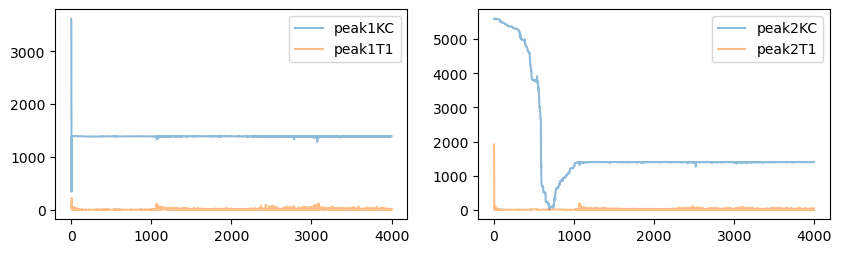

In [14]:
plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.plot(gen_loss['peak1KC'],label='peak1KC',alpha=0.5)
plt.plot(gen_loss['peak1T1'],label='peak1T1',alpha=0.5)
plt.legend()

plt.subplot(2,2,2)
plt.plot(gen_loss['peak2KC'],label='peak2KC',alpha=0.5)
plt.plot(gen_loss['peak2T1'],label='peak2T1',alpha=0.5)
plt.legend()

# plt.subplot(2,2,3)
# plt.plot(gen_loss['left_mitigation_peak1KC'],label='left_mitigation_KC',alpha=0.5)
# plt.plot(gen_loss['right_mitigation_peak1KC'],label='right_mitigation_KC',alpha=0.5)
# plt.legend()

# plt.subplot(2,2,4)
# plt.plot(gen_loss['left_mitigation_peak2T1'],label='left_mitigation_T1',alpha=0.5)
# plt.plot(gen_loss['right_mitigation_peak2T1'],label='right_mitigation_T1',alpha=0.5)
# plt.legend()

In [40]:

def wasserstein_loss(y_true, y_pred):
	return -1*backend.mean(y_true * y_pred)

In [50]:
modelgen.compile(optimizer=keras.optimizers.RMSprop(lr=0.0003),
         loss=wasserstein_loss)

In [10]:
class SequenceFeeder(tf.keras.utils.Sequence):

    def __init__(self, x_set, batch_size, max_data=2**20, WINDOW=10000):
        self.x = x_set
        self.batch_size = batch_size
        self.WINDOW = WINDOW
        self.max_data = max_data
        self.all_indices = np.arange(len(x_set) - WINDOW + 1)
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        window_indices = batch_indices.reshape(-1, 1) + np.arange(self.WINDOW).reshape(1, -1)
        batch_x = self.x[window_indices]
        return batch_x 
        
    def on_epoch_end(self):
        self.indices = np.random.choice(self.all_indices, size=self.max_data, replace=False)

In [51]:
x_train = SequenceFeeder(X_2L.astype('float32'), batch_size=1, max_data=1)
DLOSS=[]
GLOSS=[]
for i in range(100):
    history=modelgen.fit(tf.random.normal((1, 10)),tf.ones((1,1)), epochs=1)
    labels = tf.concat([-1*tf.ones((1, 1)), tf.ones((1, 1))], axis=0)
    random_latent_vectors = tf.random.normal(shape=(1, 10))
    generated_sequences = modelgen.predict(random_latent_vectors)
    combined_sequences = tf.concat([generated_sequences, np.array(x_train).reshape(1,10000,4)], axis=0)
    predictions = modeldis.predict(combined_sequences)
    d_loss = (1+wasserstein_loss(labels, predictions))
    DLOSS.append(d_loss)
    GLOSS.append(history.history['loss'])


1/1 [==============================] - 0s 9ms/step
